# Yandex Data Science School
## Linear Regression & Regularization Exercise.
### Written by Dr. Hanan Shteingart.

## Outline
In this exercise you will learn the following topics:

1. Refresher on how linear regression is solved in batch and in Gradient Descent 
2. Implementation of Ridge Regression
3. Comparing Ridge, Lasso and vanila Linear Regression on a dataset

## Refresher on Ordinary Least Square (OLS) aka Linear Regeression

### Lecture Note

In Matrix notration, the matrix $X$ is of dimensions $n \times p$ where is each row is an example and each column is a feature dimension. 

Similarily, $y$ is of dimension $n \times 1$ and $w$ is of dimensions $p \times 1$.

The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as resiudal sum of squares (RSS): 

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ (to see why, read about [matrix derivatives](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) or see class notes )

Thus, the gardient descent solution is $w'=w-\eta \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

See [lecture note from Stanford](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf) for more details.


## Exercise 1 - Ordinary Least Square
* Get the boston housing dataset by using the scikit-learn package. hint: [load_boston](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

* What is $p$? what is $n$ in the above notation? hint: [shape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.shape.html)

* write a model `OrdinaryLinearRegression` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score` (which returns the MSE on a given sample set). Hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

* Fit the model. What is the training MSE?

* Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$

* Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? Hint: use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

* Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value? Hint: use [scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html). 

* Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. Plot the class convergance. What is the effect of learning rate? How would you find number of iteration automatically? Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your features first.

* **Bonus:** Repeat for coordinate descent by creating a new class `OrdinaryLinearRegressionCoordinateDescent` which also inherits from `OrdinaryLinearRegression`. Compare the learning curves.


In [199]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston

In [200]:
X, y = load_boston(return_X_y=True)
n = X.shape[0]
p = X.shape[1]

print("n = %d, p = %d" % (n, p))

n = 506, p = 13


In [201]:
class OrdinaryLinearRegression:
    def __init__(self):
        self.w = []
    
    # 1. copies original X
    # 2. makes sure X has 2 dims
    # 3. adds ones column
    def _add_ones_to_X(self, X):
        X_copy = X.copy()
        # treat 1-dimensional X
        if (len(X_copy.shape) == 1):
            # make sure X is 2-dimensional
            X_copy = X_copy.reshape(-1, 1)
        # add ones vector to X, the biases
        ones_vec = np.ones(shape = X_copy.shape[0]).reshape(-1, 1)
        X_copy = np.concatenate((ones_vec, X_copy), 1)
        return X_copy
    
    def fit(self, X, y):
        X_copy = self._add_ones_to_X(X)
        self.w = (np.linalg.inv(X_copy.transpose().dot(X_copy))
                    .dot(X_copy.transpose()).dot(y))
    
    def _predict_one_sample(self, sample):
        w0 = self.w[0]
        prediction = w0
        prediction += sample.dot(self.w[1:])
        return prediction
    
    def predict(self, X_to_predict):
        y_preds = np.apply_along_axis(self._predict_one_sample, 1, X_to_predict)
        return y_preds
    
    def score(self, X_sample, y_sample):
        y_preds = self.predict(X_sample)
        return np.mean(np.square(y_sample - y_preds))

<i>What is the training MSE?</i>

In [202]:
regressor = OrdinaryLinearRegression()
regressor.fit(X, y)
# training MSE
regressor.score(X, y)

21.894831181729202

<i>Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$</i>

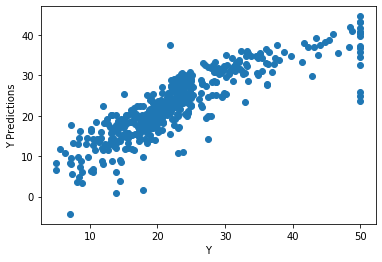

In [203]:
y_preds = regressor.predict(X)
plt.xlabel("Y")
plt.ylabel("Y Predictions")
plt.plot(y, y_preds, 'o');

<i>Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test?</i>

<i>Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value?</i>

In [219]:
from sklearn.model_selection import train_test_split
from scipy import stats

def average_mse_train_test_with_t_statistic(regressor, num_tries=20):
    accumulate_mse_train = []
    accumulate_mse_test = []
    for i in range(20):
        X_train, X_test, y_train, y_test \
            = train_test_split(X, y, test_size=0.25)
        regressor.fit(X_train, y_train)
        # training MSE
        accumulate_mse_train.append(regressor.score(X_train, y_train))
        # test MSE
        accumulate_mse_test.append(regressor.score(X_test, y_test))

    print("average train mse = %f" % np.mean(accumulate_mse_train))
    print("average test mse = %f" % np.mean(accumulate_mse_test))
    
    # Null Hypothesis - training MSE and test MSE are similar
    # Alternate Hypothesis - training MSE is significantly smaller than test MSE
    # We will use, Paired T-Test - which is implemented in scipy.stats.ttest_rel
    t_statistic, p_value = stats.ttest_rel(accumulate_mse_train,accumulate_mse_test)
    print("t_statistic = %f, p_value = %f" % (t_statistic, p_value))

average_mse_train_test_with_t_statistic(OrdinaryLinearRegression())

average train mse = 20.671835
average test mse = 27.041678
t_statistic = -4.512094, p_value = 0.000239


Our p-value is bellow the standard thresholds of 0.05 or 0.01, so we reject the null hypothesis and we can say that the training MSE is significantly lower than the test MSE.

<i>Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. </i>


In [220]:
class OrdinaryLinearRegressionGradientDescent(OrdinaryLinearRegression):
    def __init__(self, alpha=0.1, num_iterations=100):
        self.alpha = alpha
        self.num_iterations = num_iterations
    
    def _cost(self, X, y, weights):
        n_samples = X.shape[0]
        h = np.dot(X, weights)
        return 0.5 * (1 / n_samples) * np.sum((h - y)**2)
        
    def _normalize_data(self, X):
        # mu / sigma
        return (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    def _gradient_descent(self, X, y, weights):
        n_samples = X.shape[0]
        cost_history = np.zeros((self.num_iterations, 1))
        for i in range(self.num_iterations):
            # partial derivative 
            weights = (weights - self.alpha * 
                       (1/n_samples)* X.transpose().dot((X.dot(weights) - y)))
            cost_history[i] = self._cost(X, y, weights)
        return (cost_history, weights)
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        n_features = X.shape[1]
        
        # normalize X values and add ones column
        X_copy = self._normalize_data(X)
        X_copy = super()._add_ones_to_X(X_copy)
        
        y_copy = y.copy().reshape(-1, 1)
        
        # initalize weights with zeros
        weights = np.zeros((n_features + 1, 1))
        #initial_cost = self._cost(X_copy, y_copy, weights)
        
        (self.cost_history, self.optimal_weights) = self._gradient_descent(X_copy, y_copy, weights)
        return (self.cost_history, self.optimal_weights)
    
    def predict(self, X_to_predict):
        n_samples = X_to_predict.shape[0]
        X_to_predict_copy = self._normalize_data(X_to_predict)
        X_to_predict_copy = super()._add_ones_to_X(X_to_predict_copy)
        y_pred = X_to_predict_copy.dot(self.optimal_weights)
        return y_pred
    
    def score(self, X_sample, y_sample):
        y_preds = self.predict(X_sample)
        y_sample_copy = y_sample.copy().reshape(-1, 1)
        score = 1 - (np.sum((y_sample_copy - y_preds) ** 2) / np.sum((y_sample_copy - y_sample_copy.mean()) ** 2))
        return score

In [92]:
# doing the same MSE calculation as we did for OLS, to verify our model
# is working as expected

average_mse_train_test_with_t_statistic(OrdinaryLinearRegressionGradientDescent())

average train mse = 0.742675
average test mse = 0.701969
t_statistic = 2.952670, p_value = 0.008174


<i>Plot the class convergance.</i>

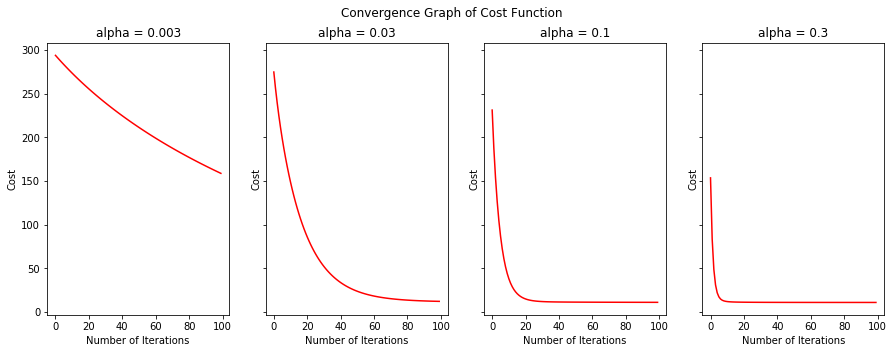

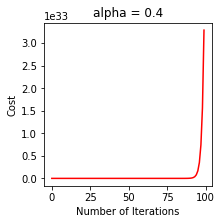

In [93]:
num_iterations = 100
alphas = [0.003, 0.03, 0.1 , 0.3]

fig, ax_tuple = plt.subplots(1, len(alphas), figsize=(15,5), sharex=True, sharey=True)
fig.suptitle('Convergence Graph of Cost Function')

for i, alpha in enumerate(alphas):
    regressor = OrdinaryLinearRegressionGradientDescent(alpha, num_iterations)
    cost_history, optimal_weights = regressor.fit(X,y)
    ax_tuple[i].plot(range(num_iterations), cost_history, 'r')
    ax_tuple[i].set_title('alpha = ' + str(alpha))
    ax_tuple[i].set_xlabel('Number of Iterations')
    ax_tuple[i].set_ylabel('Cost')

plt.show();

# example of a too large alpha
alpha = 0.4
regressor = OrdinaryLinearRegressionGradientDescent(alpha, num_iterations)
cost_history, optimal_weights = regressor.fit(X,y)
plt.figure(figsize=(3,3))
plt.plot(range(num_iterations), cost_history, 'r')
plt.title("alpha = " + str(alpha))
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")

plt.show();

<i>What is the effect of learning rate?</i>

The learning rate directly influences how much we are "nudging" the weight in every iteration.

In case the chosen learning rate is too small, our model will need a very large number of iterations in order to converge - i.e. convergence will be too slow.

In case the chosen learning rate is too large, our model will keep "missing" the optimal minimum - i.e. the cost function will not decrease on every iteration, and thus may not converge.

<i>How would you find number of iteration automatically?</i>

We can for example declare a small convergence threshold, such as $\varepsilon = {10^{-3}}$.

Then we can check wether our cost function decreases by less than the threshold in a single iteration

<i>Why doesn't Gradient Descent work well when features are not scaled evenly?</i>

When features are not scaled evenly, GD will give more weight to larger-scaled features, regardless whether or not these features are actually more influential.
Thus we need to normalize all the features in a given dataset when preparing it for Gradient Descent, which typically mean rescaling all values into a [0,1] range.

This technique will boost our model's accuracy while lowering the cost (error). 

<i><h4>Bonus:</h4> 

Repeat for coordinate descent by creating a new class OrdinaryLinearRegressionCoordinateDescent which also inherits from OrdinaryLinearRegression.</i>

In [94]:
class OrdinaryLinearRegressionCoordinateDescent(OrdinaryLinearRegression):
    def __init__(self, num_iterations=100):
        self.num_iterations = num_iterations
    
    # normalizing so that sum of the squared normalized values will equal 1
    def _normalize_data(self, X):
        # addings ones column
        X_new = super()._add_ones_to_X(X)
        # keep denominator for prediction usage
        self.normalization_denominator = np.sqrt(np.sum(np.square(X_new), axis=0))
        X_Normalized = X_new / self.normalization_denominator
        return X_Normalized
    
    def _cost(self, X, y, weights):
        n_samples = X.shape[0]
        h = np.dot(X, weights)
        return (1 / 2 *  n_samples) * np.sum((h - y)**2)

    
    def fit(self, X, y):
        X_Normalized = self._normalize_data(X)

        weights = np.zeros(X_Normalized.shape[1])
        cost_history = np.zeros((self.num_iterations, 1))
        for i in range(self.num_iterations):
            r = y - X_Normalized.dot(weights)
            for j in range(len(weights)):
                r = r + X_Normalized[:, j] * weights[j]
                # update weight j
                weights[j] = X_Normalized[:, j].dot(r)
                r = r - X_Normalized[:, j] * weights[j]
            cost_history[i] = self._cost(X_Normalized, y, weights)
        
        self.optimal_weights = weights
        return (cost_history, weights)
    
    def predict(self, X_to_predict):
        n_samples = X_to_predict.shape[0]
        
        inter = np.ones(X_to_predict.shape[0])
        X_to_predict_new = np.column_stack((inter, X_to_predict))

        # normalize using denominator calculated when training
        X_to_predict_normalized = X_to_predict_new / self.normalization_denominator
                                    
        y_pred = X_to_predict_normalized.dot(self.optimal_weights)
        return y_pred
    
    def score(self, X_sample, y_sample):
        y_preds = self.predict(X_sample)
        score = 1 - (np.sum((y_sample - y_preds) ** 2) / np.sum((y_sample - y_sample.mean()) ** 2))
        return score

In [95]:
average_mse_train_test_with_t_statistic(OrdinaryLinearRegressionCoordinateDescent(100))

average train mse = 0.732069
average test mse = 0.674125
t_statistic = 4.163347, p_value = 0.000528


<i>Compare the learning curves.</i>

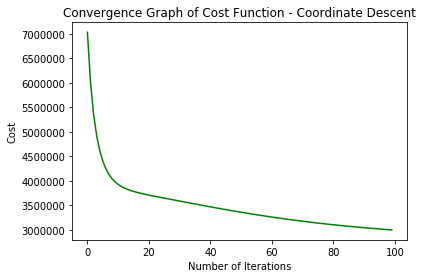

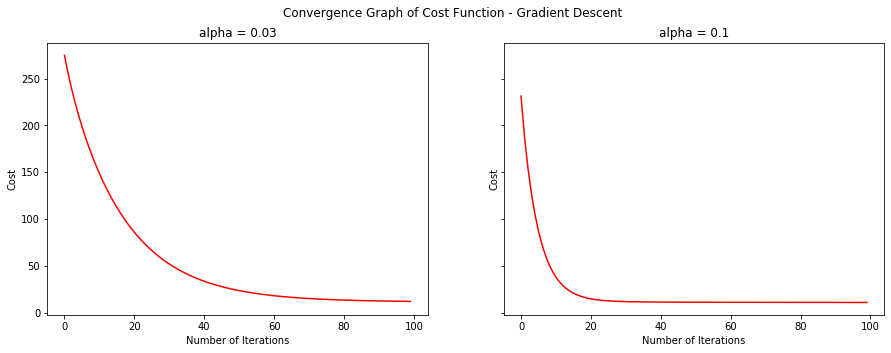

In [96]:
num_iterations = 100

regressor = OrdinaryLinearRegressionCoordinateDescent(num_iterations)
cost_history, optimal_weights = regressor.fit(X,y)
#plt.figure(figsize=(3,3))
plt.plot(range(num_iterations), cost_history, 'g')
#plt.title("alpha = " + str(alpha))
plt.title('Convergence Graph of Cost Function - Coordinate Descent')
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")

plt.show();


alphas = [0.03, 0.1]

fig, ax_tuple = plt.subplots(1, len(alphas), figsize=(15,5), sharex=True, sharey=True)
fig.suptitle('Convergence Graph of Cost Function - Gradient Descent')

for i, alpha in enumerate(alphas):
    regressor = OrdinaryLinearRegressionGradientDescent(alpha, num_iterations)
    cost_history, optimal_weights = regressor.fit(X,y)
    ax_tuple[i].plot(range(num_iterations), cost_history, 'r')
    ax_tuple[i].set_title('alpha = ' + str(alpha))
    ax_tuple[i].set_xlabel('Number of Iterations')
    ax_tuple[i].set_ylabel('Cost')

plt.show();


Coordinate Descent converges faster than Gradient Descent, depending on the chosen alpha.
In case chosen alpha is 0.1, Gradient Descent will converge faster.

## Exercise 2 - Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\frac{1}{N}\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2$

* Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$
* Change `OrdinaryLinearRegression` and `OrdinaryLinearRegressionGradientDescent` classes to work also for ridge regression (do not use the random noise analogy but use the analytical derivation). Either add a parameter, or use inheritance.
* **Bonus: Noise as a regularizer**: Show that OLS (ordinary least square), if one adds multiplicative noise to the features the **average** solution for $W$ is equivalent to Ridge regression. In other words, if $X'= X*G$ where $G$ is an uncorrelated noise with variance $\sigma$ and mean 1, then solving for $X'$ with OLS is like solving Ridge for $X$. What is the interpreation? 



<i>Ridge proof - Differentiating</i>

The original loss function is:

$$f(\beta) = (Y - X\beta)^T(Y - X\beta)$$

Adding the Ridge panelty will result with:

$$f(\beta) = (Y - X\beta)^T(Y - X\beta) + \lambda\beta^T\beta$$

Which we wish to minimize:

$$\min_{\beta}[(Y - \beta^TX)^T(Y - \beta^TX)+\lambda\beta^T\beta]$$

Deriving $f(\beta)$ w.r.t. $\beta$ will result with the following:

$$\frac{\partial(Y - X\beta)^T(Y - X\beta)}{\partial \beta} = -2X^T(Y - \beta^TX)$$


$$\frac{\partial \lambda\beta^T\beta}{\partial \beta} = 2\lambda\beta$$

Which leads to, when equating to 0:

$$f'(\beta) = 0$$

$$-2X^T(Y - \beta^TX) + 2\lambda\beta = 0$$

$$X^TY = X^TX\beta + \lambda\beta$$

Isolating $\beta$ leads to:

$$\beta = (X^TX + \lambda I)^-1X^TY$$

In [170]:
class OrdinaryLinearRegressionWithRidge(OrdinaryLinearRegression):
    def __init__(self, penalty_lambda):
        super().__init__()
        self.penalty_lambda = penalty_lambda
    
    def fit(self, X, y):
        X_copy = self._add_ones_to_X(X)
        self.w = (np.linalg.inv(
            X_copy.transpose().dot(X_copy) + self.penalty_lambda * np.identity(X_copy.shape[1]))
                    .dot(X_copy.transpose()).dot(y))

average_mse_train_test_with_t_statistic(OrdinaryLinearRegressionWithRidge(0))

# o = OrdinaryLinearRegressionWithRidge(0)
# X_train, X_test, y_train, y_test \
#             = train_test_split(X, y, test_size=0.25)
# o.fit(X_train, y_train)
# o.predict(X_train)

average train mse = 21.289871
average test mse = 25.219978
t_statistic = -2.663493, p_value = 0.015350


In [174]:
class OrdinaryLinearRegressionGradientDescentWithRidge(OrdinaryLinearRegressionGradientDescent):
    
    def __init__(self, penalty_lambda, alpha=0.1, num_iterations=100):
        super().__init__(alpha, num_iterations)
        self.penalty_lambda = penalty_lambda
    
    def _gradient_descent(self, X, y, weights):
        n_samples = X.shape[0]
        cost_history = np.zeros((self.num_iterations, 1))
        for i in range(self.num_iterations):
            # partial derivative 
            weights = (weights - self.alpha * (1/n_samples)* X.transpose().dot((X.dot(weights) - y))
                + self.penalty_lambda * (1/n_samples) * weights)
            
            cost_history[i] = self._cost(X, y, weights)
        return (cost_history, weights)
    
    def score(self, X_sample, y_sample):
        y_preds = self.predict(X_sample)
        return np.mean(np.square(y_sample - y_preds))

average_mse_train_test_with_t_statistic(OrdinaryLinearRegressionGradientDescentWithRidge(0))

# o = OrdinaryLinearRegressionGradientDescentWithRidge(0)
# X_train, X_test, y_train, y_test \
#             = train_test_split(X, y, test_size=0.25)
# o.fit(X_train, y_train)
# o.predict(X_train)


average train mse = 150.215151
average test mse = 139.847113
t_statistic = 2.863554, p_value = 0.009943


In [369]:
# Noise

class OrdinaryLinearRegressionWithGaussianNoise(OrdinaryLinearRegression):
    
    def __init__(self, num_iterations):
        self.num_iterations = num_iterations
    
    def fit(self, X, y):
        n_features = X.shape[1]
        sigma = 0.01
        accumulated_weights = np.empty((0, n_features + 1), float)
        for iteration in range(self.num_iterations):
            noise = np.random.normal(loc=1, scale=sigma, size=X.shape) # Gaussian distribution
            X_copy = self._add_ones_to_X(X * noise)
            current_weights = (np.linalg.inv(X_copy.transpose().dot(X_copy))
                        .dot(X_copy.transpose()).dot(y))
            current_weights = current_weights.reshape(1, current_weights.shape[0])
            accumulated_weights = np.append(accumulated_weights, current_weights , axis=0)
        
        # average weights
        self.w = np.mean(accumulated_weights, axis=0)
            

average_mse_train_test_with_t_statistic(OrdinaryLinearRegressionWithGaussianNoise(100))

# o = OrdinaryLinearRegressionWithGaussianNoise(100)
# X_train, X_test, y_train, y_test \
#             = train_test_split(X, y, test_size=0.25)
# o.fit(X_train, y_train)
# o.predict(X_train)

# http://madrury.github.io/jekyll/update/statistics/2017/08/12/noisy-regression.html

average train mse = 21.633085
average test mse = 24.093736
t_statistic = -1.604394, p_value = 0.125121


Adding multiplicative random noise to the data causes the data points to spread out more - i.e. become more dispresed.

When fitting a linear regression to the spread-out data points, the slope becomes more depressed.

Because we are expected to get a different result each time we add different random noise to the data, we average the result per the used $\sigma$. The average line is called  


http://madrury.github.io/jekyll/update/statistics/2017/08/12/noisy-regression.html

## Exercise 3 - Lasso Linear Regression

As we've seen in class, Lasso Regression is a regularization technique with $L_1$ penalty on weights. This techniques creates sparse weights (some weights become effectively zero). Programming a Lasso solver is a challange and is left as an optional exercise below.
This exercise will focus on the analysis of the different regularization techniques over a toy problem using the scikit-learn implementation.

### Data generation: 1-D Polynomal Regression
```
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

```

* Use the preprocessing transformer `sklearn.preprocessing.PolynomialFeatures` in order to create a feature space. Note, you can use `sklearn.pipeline.Pipeline` in order to create an effective model which does the preprocessing (not essential).
* Use `sklearn.model_selection.cross_val_score` to evaluate each of the linear model provided by Scikit-learn (`from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV`) and compare the performance over the different `degrees`. To do so, create a 3x3 plot where each row correspond to one model and each column to one degree. Each plot should plot the train data as well as the true model and the fitted one (use 100 points in the range [0,1]) and the CV (cross validation) MSE. What is the take home message? (Note: RidgeCV and LassoCV do an internal cross-validation to determin the regularization parameter.)
* Weights spectrum: change the `alpha` parameter gradually (on a logartithmic scale) and observe how the coefficients change for `degrees=5` over alpha for Ridge and Lasso. What is the take home message?

In [175]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 100
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

In [178]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

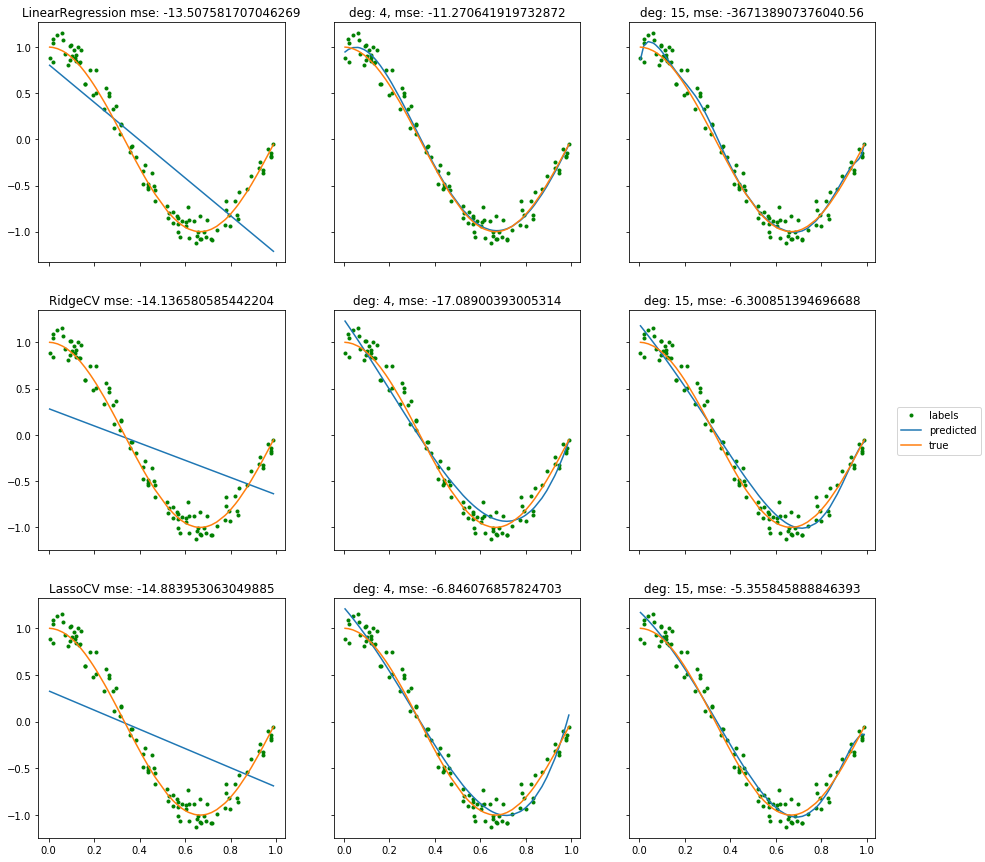

In [179]:
@ignore_warnings(category=ConvergenceWarning)
def plot():

    models = [LinearRegression(), RidgeCV(cv=3), LassoCV(cv=3,max_iter=1000)]

    fig, axs = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15,15))

    for i, model in enumerate(models):
        for j, degree in enumerate(degrees):
            poly = PolynomialFeatures(degree)
            X_trans = poly.fit_transform(X.reshape(-1,1))
            model.fit(X_trans, y)
            y_hat = model.predict(X_trans)
            axs[i][j].plot(X, y, '.g', label='labels')
            axs[i][j].plot(X, y_hat, label='predicted')
            axs[i][j].plot(X, true_fun(X), label='true')
            cvs = cross_val_score(model, X_trans, y, cv=3).mean()
            if j == 0:
                axs[i][j].title.set_text(type(model).__name__ + ' mse: ' + str(cvs))
            else:
                axs[i][j].title.set_text('deg: ' + str(degree) + ', mse: ' + str(cvs))
        
    handles, labels = axs[-1][-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')

plot()

<i>Take Home Message</i>

We can see that all Regressors with degree 1 are biased, since the data is non-linear. The regularized regressors are even worse than vanilla in that case (because they introduce an overfitting penalty for a model that underfits).

In degree 4, Vanilla LR performs better than Ridge, probably because the L2 penalty is not a good regularization for this degree of complexity (e.g. it's better to let coefficents "grow" naturally than to penalize by the L2 norm).
Lasso is performing much better for degree 4, probably because L1 norm,  which penalizes less drastically on higher values, works better for a relatively low degree.

In degree 15, we see that Vanilla LR is completely overfitting, while Ridge is performing pretty well and Lasso is the best.
We think that both Ridge and Lasso have a lot more information to use now, and the L2 regularization is useful to tame the effect of high degree features, while allowing the model to learn useful information from them.

Ridge error is still higher than Lasso since it can't zero out coefficents completely (because of the L2 norm), so some overfitting still takes place.

<i><b>Weights spectrum:</b></i>

In [193]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import pandas as pd

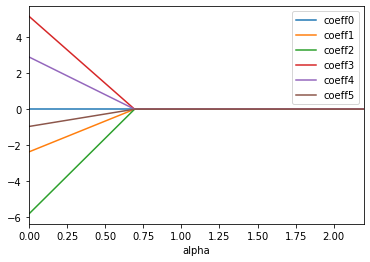

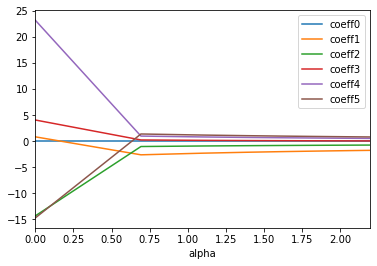

In [197]:
@ignore_warnings()
def plot():
    alphas = np.log(np.arange(1.0, 10.0, 1.0))
    poly = PolynomialFeatures(5)
    X_trans = poly.fit_transform(X.reshape(-1,1))
    cols = ['model', 'alpha']
    cols  +=  ['coeff' + str(i) for i in range(X_trans.shape[1])]
    #print(cols)
    df = pd.DataFrame(columns=cols)
    i=0
    for alpha in alphas:
        models = [Ridge(alpha=alpha), Lasso(alpha=alpha)]
        for model in models:
            model.fit(X_trans, y)
            model_alpha = {'model':type(model).__name__, 'alpha':alpha}
            coeffs = {}
            for k in range(X_trans.shape[1]):
                coeffs['coeff' + str(k)] = model.coef_[k]

            row = {**coeffs, **model_alpha}
            df.loc[i] = pd.Series(row)
            i += 1
    # df = df.fillna(0) 
    df.set_index('alpha', inplace=True)
    df.groupby(['model']).plot()
    
plot()

<i>Take Home Message</i>

We see that Ridge penalizes coefficients a little slower than Lasso, and it also can't zero them out, as opposed to Lasso. In addition, we see that L2 norm means coefficients can change sign (from positive to negative or vice versa)